In [25]:
import numpy as np
from scipy.stats import norm
import open3d as o3d
import igl
%run helpers_alg.ipynb


In [55]:


def readLbl(fileName):
    #takes in file name, returns the labels as an array
    file1 = open(fileName, 'r')
    Lines = file1.readlines()

    count = 0

    lbls = np.empty([600])
    # Strips the newline character
    for line in Lines:
        count += 1
        text = line.strip()[1:].split('.')
        text[1] = text[1].split(' ')[1]
        lbls[int(text[0])] = int(text[1])
        #print("Line{}: {}".format(count, )))
    return lbls


def lbl_2_lblMat(lbls):
    #takes in the labels as an array, returns an adjacency matrix between objects of same label
    labelMat = igl.all_pairs_distances(lbls, lbls, False)
    labelMat = np.where(labelMat > 0.5, 1, 0)
    return labelMat


def compareGroups(grpa, grpb, lbl, disSMat):
    #takes in two group indices, labels and dissimiliarity matrix, returns how similar they are as two groups
    grpA_idx = np.reshape(np.where(lbl == grpa), (20,))
    grpB_idx = np.reshape(np.where(lbl == grpb), (20,))
    A = disSMat[grpA_idx, :]
    B = A[:, grpB_idx]

    result = np.mean(B)

    if (grpa - grpb < 0.1):
        result = result * 20 / 19

    return result

# Test: DownSample Mesh

In [70]:
def obj_2_mesh(fileName):
    mesh = o3d.io.read_triangle_mesh(mesh_dir + fileName)
    # try different ways of downsampling method

    # combine closet vertices to form 250 faces -- not effective
    # simp_mesh = o3d.geometry.TriangleMesh.simplify_quadric_decimation(mesh, 250)
    # simp_mesh.compute_vertex_normals()

    simp_mesh = mesh.filter_smooth_laplacian(number_of_iterations=50)
    # simp_mesh.compute_vertex_normals()

    # simp_mesh= mesh.filter_smooth_taubin(number_of_iterations=50)


    v = np.asarray(simp_mesh.vertices)
    f = np.asarray(simp_mesh.triangles)
    print(v[0])
    print(f[0])
    return v, f

In [71]:

def obj_2_adj(v, f):
    #takes in file name, reads the .obj file and returns adjacency matrix scaled with edge values
    distances = igl.all_pairs_distances(v, v, False)
    adJ = igl.adjacency_matrix(f).toarray() * distances
    return adJ


def adj_2_features(adj):
    #some arbitrary ad-hoc function for extracting features, for testing only

    #print([np.mean(adj),np.max(adj),np.std(adj)])
    #hist = np.histogram(adj,bins = np.arange(0,0.5,0.02),density=True)
    #generic_feat = np.array([np.mean(adj),np.max(adj),np.std(adj)])
    hist = np.histogram(adj, bins=20, density=True)[0]
    #print(hist[0])

    return hist

In [72]:
mesh_dir = 'SHREC11/'
#ts = np.array([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4])
ts = np.random.random(500) * 0.1

In [73]:
adjMats = []

for i in range(600):
    fName = 'T' + str(i) + '.obj'
    v, f = obj_2_mesh(fName)
    adj = obj_2_adj(v, f)
    adjMats.append(adj)

[-0.29427714 -0.0336036  -0.12505579]
[0 1 2]
[-0.56910894  0.05324712 -0.01868885]
[0 1 2]
[-0.22138751 -0.18855305 -0.01925842]
[0 1 2]
[-0.06576615 -0.07910799  0.01598148]
[0 1 2]
[-0.25754484 -0.07646525 -0.21292385]
[0 1 2]
[-0.06521064  0.01199769 -0.14988288]
[0 1 2]
[-0.35789419 -0.12534901  0.04465699]
[0 1 2]
[-0.31740527 -0.09178643  0.0130167 ]
[0 1 2]
[-0.3016923  -0.06289231 -0.00072643]
[0 1 2]
[ 0.28238729  0.43676317 -0.0866498 ]
[0 1 2]
[ 0.13855151 -0.10630316 -0.11115422]
[0 1 2]
[0.17019547 0.08057043 0.00308966]
[0 1 2]
[ 0.45962015  0.06799179 -0.03609682]
[0 1 2]
[-0.35668733  0.11197633  0.02596351]
[0 1 2]
[ 0.1487116  -0.26348303  0.23025968]
[0 1 2]
[0.09717925 0.02040175 0.47982465]
[0 1 2]
[-0.59197552  0.06134859  0.04963533]
[0 1 2]
[-0.45934619  0.31405941  0.47068326]
[0 1 2]
[-0.10890279 -0.04857457  0.22613616]
[0 1 2]
[ 0.48059805 -0.14472878  0.03223186]
[0 1 2]
[0.2546729  0.16552777 0.01408993]
[0 1 2]
[-0.21760775  0.02245361 -0.03293977]
[0 1 

In [74]:
lapMats = adj_mat_to_lap_mat(adjMats)

In [ ]:
evals,Us = lap_mat_to_eigen(lapMats)
hkss = batch_heat_kernel_signature(ts, evals, Us)

In [ ]:
disSimMat = igl.all_pairs_distances(hkss,hkss,True)

In [ ]:
disSimMat = disSimMat / np.max(disSimMat)

In [ ]:
label = readLbl(mesh_dir+'labels.txt')
compResult = compareGroups(0,1,label,disSimMat)
np.mean(compResult)

In [65]:
disSimMat2 = disSimMat + np.diag(np.ones(600))
print(divmod(np.argmin(disSimMat2),600))
print(np.min(disSimMat2))
print(label[59])
print(label[191])

(331, 363)
5.850441507435726e-11
13.0
19.0


In [66]:
mat = np.empty([30,30])
compSelf = []
compOthers = []
for i in range(30):
    for j in range(0,i+1):
        compResult = compareGroups(i,j,label,disSimMat)
        mat[i,j] = compResult
        mat[j,i] = compResult
        if (i == j):
            compSelf.append(compResult)
        else:
            compOthers.append(compResult)

In [67]:
print(np.min(compSelf))
print(compOthers.index(np.min(compOthers)))

0.000791398824095184
247


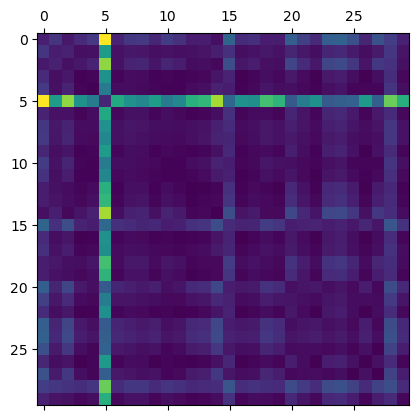

In [68]:
plt.matshow(mat)
self_mean = np.mean(compSelf)
self_std = np.std(compSelf)
others_mean = np.mean(compOthers)
others_std = np.std(compOthers)

In [1]:
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-0.3, 0.3, 0.001)

#plt.hist(compSelf)


plt.plot(x_axis, norm.pdf(x_axis, self_mean, self_std))
plt.plot(x_axis, norm.pdf(x_axis, others_mean, others_std))
plt.show()

NameError: name 'np' is not defined